## <p style='text-align: center; font-family:"Times New Roman"'> Multinomial Naive bayes classifier- Regression Logistique  (TFIDF) </p> 

****

<span style="color: DimGray"> **1.1 Importation des bibliothèques**  </span>

In [34]:
import pandas as pd 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,f1_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score


<span Style="color: DimGray"> **1.2 Importation des données**</span> 

In [2]:
colonnes= ['ids', 'Target', 'text']
df1 = pd.read_csv('datasets\Sentiment140-MV-Train.csv',names=colonnes)
df2=pd.read_csv('datasets\Sentiment140-MV-Test.csv',names=colonnes)
df = pd.concat([df1, df2], ignore_index=True)

In [3]:
df.head()

,ids,Target,text
0,1834873030,1,USER_MENTION oh that sounds yummy we dont have...
1,2062647136,0,USER_MENTION theres so many fakes of you
2,2013029024,1,USER_MENTION um nothing new apart from street ...
3,2184368404,1,USER_MENTION USER_MENTION the day cnn started ...
4,2214865531,0,missing my dad my brother today


<span style="color:DimGray"> **1.3 exploration des données**</span>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19995 entries, 0 to 19994
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ids     19995 non-null  int64 
 1   Target  19995 non-null  int64 
 2   text    19995 non-null  object
dtypes: int64(2), object(1)
memory usage: 468.8+ KB


In [5]:
df.isnull().sum()

ids       0
Target    0
text      0
dtype: int64

In [6]:
df.duplicated().sum()

1782

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df['Target'].value_counts()

Target
1    11628
0     6585
Name: count, dtype: int64

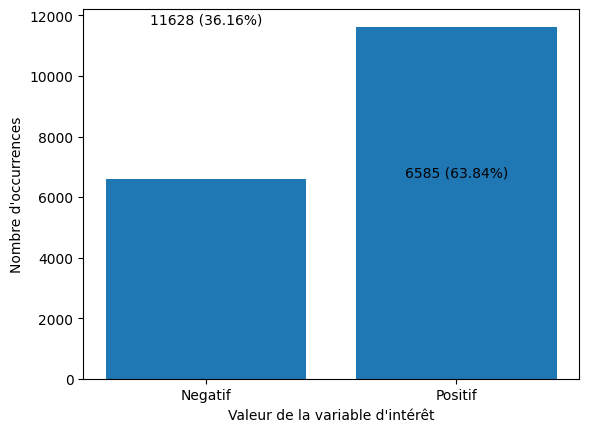

In [9]:
target_counts = df['Target'].value_counts()

# Calcul du proportion pour chaque valeur de la variable d'intérêt (Target)
target_proportions = df['Target'].value_counts(normalize=True)

# Création d'un graphique à barres pour visualiser la distribution
plt.bar(target_counts.index, target_counts.values)

# Ajoute des étiquettes des barres (nombre d'occurrences et proportion)
for i, count in enumerate(target_counts):
    proportion = target_proportions[i]
    plt.text(i, count, f"{count} ({proportion:.2%})", ha='center', va='bottom')

# Étiquetage de l'axe des x et y
plt.xlabel('Valeur de la variable d\'intérêt')
plt.ylabel('Nombre d\'occurrences')

# Ajoute d'une légende aux barres
plt.xticks(target_counts.index, ['Positif', 'Negatif'])

# Affichage du graphique
plt.show()

In [10]:
import re 
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [11]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [13]:
def lemmitizer(content):
    # Suppression des caractères non alphabétiques
    texte_nettoye = re.sub('[^a-zA-Z]', ' ', content)
    # Suppression des adresses URL
    content = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', content)
    content = content.lower()
    # Tokenization
    tokens = content.split()
    # Lemmatisation et suppression des mots vides
    lemmitized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    # Reconstruction du texte
    lemmitized_text = ' '.join(lemmitized_tokens)
    return lemmitized_text


# On applique le nettoyage du texte sur la colonne 'texte'
df['texte_nettoye'] = df['text'].apply(lemmitizer)

In [14]:
df.head()

,ids,Target,text,texte_nettoye
0,1834873030,1,USER_MENTION oh that sounds yummy we dont have...,user_mention sound yummy dont bloomingdales th...
1,2062647136,0,USER_MENTION theres so many fakes of you,user_mention there many fake
2,2013029024,1,USER_MENTION um nothing new apart from street ...,user_mention nothing new apart street fighter
3,2184368404,1,USER_MENTION USER_MENTION the day cnn started ...,user_mention user_mention day cnn started sour...
4,2214865531,0,missing my dad my brother today,missing dad brother today


In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

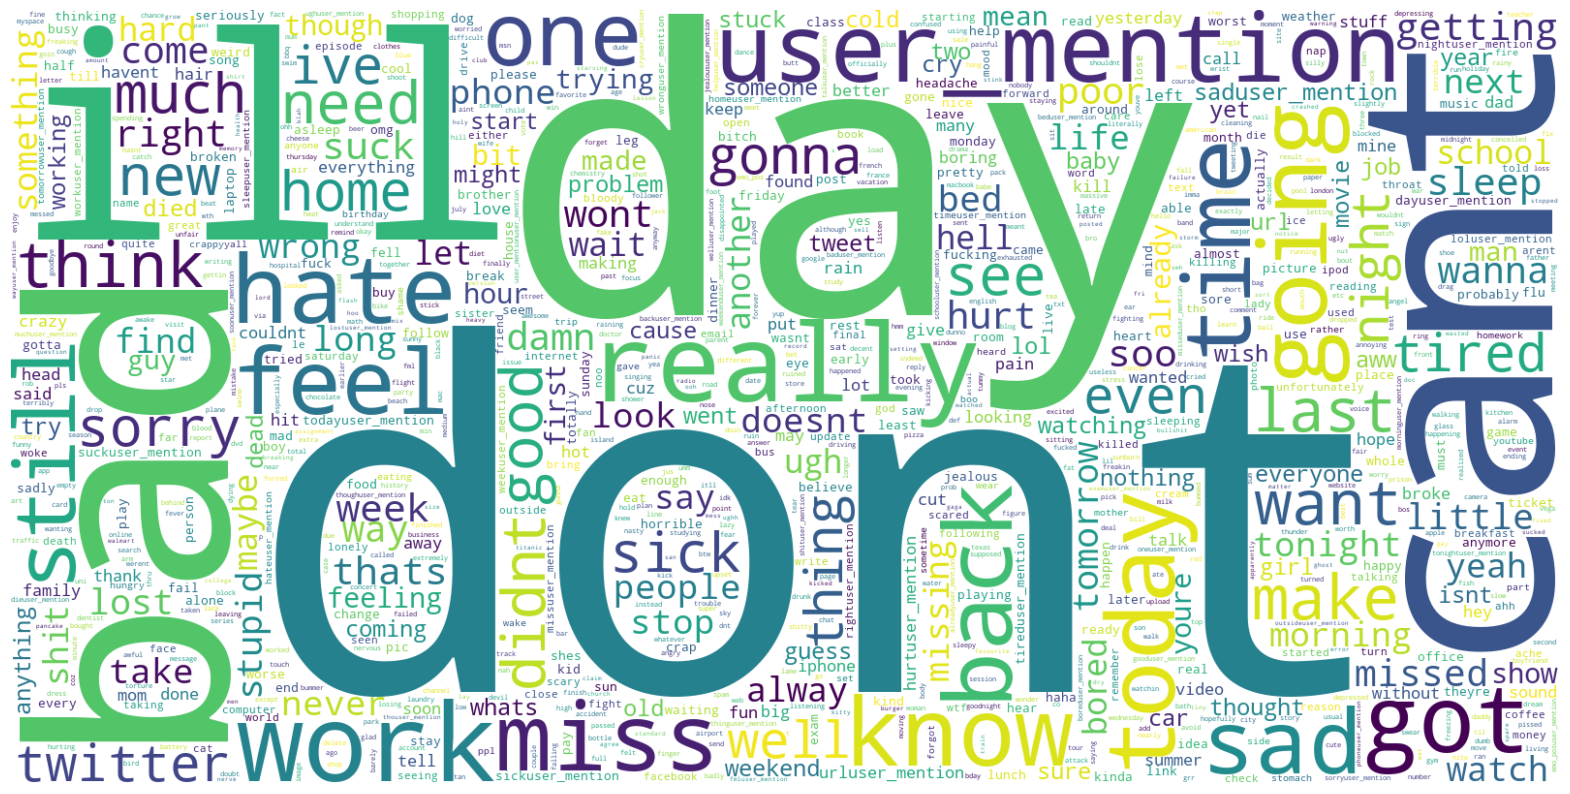

In [16]:
#filtrage des tweets Negatif 
data_neg= df[df['Target'] == 0]['texte_nettoye']

#Création d'un nuage de mots  
wc = WordCloud(max_words = 1000, width=1600, height = 800, collocations= False, background_color='white').generate("".join(data_neg))

#affichage 
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

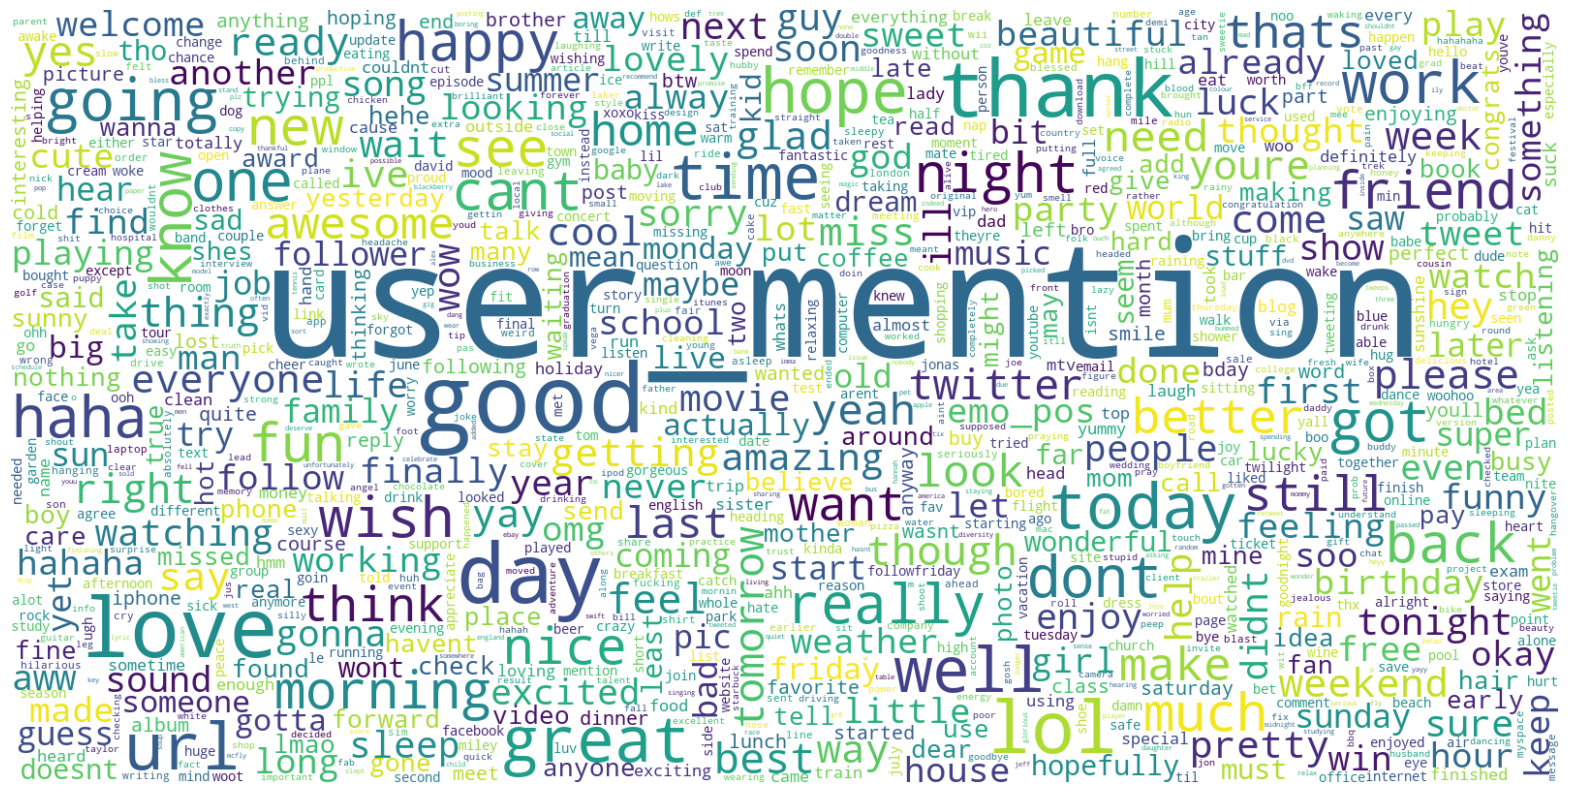

In [17]:
#filtrage des tweets posifit
data_neg = df[df['Target'] == 1]['texte_nettoye']

# Créer un nuage de mots à partir des données négatives
wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False, background_color='white').generate(" ".join(data_neg))

# Afficher le nuage de mots
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

* Séparation des données

In [18]:
# Séparation des données en features (X) et target (Y)
X = df['texte_nettoye'].values
Y = df['Target'].values

In [19]:
# Division du dataset en ensembles d'entraînement, de validation et de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42) 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer() 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train) #applying tf idf to training data

tfidf_test_vectors = tfidf_vectorizer.transform(X_test) #applying tf idf to training data

### MNB Classifier

In [21]:
from sklearn.naive_bayes import MultinomialNB
#naive bayes classifier
naive_bayes_classifier = MultinomialNB()

naive_bayes_classifier.fit(tfidf_train_vectors, y_train)

MultinomialNB()

### Regression Logistique 

In [37]:
# Import the logistic regression model from sklearn 
from sklearn.linear_model import LogisticRegression

# Define the model
model = LogisticRegression(random_state=0, solver='lbfgs',
                            multi_class='multinomial')
# Train model
model.fit(tfidf_train_vectors, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

In [22]:
y_pred = naive_bayes_classifier.predict(tfidf_test_vectors)

#### Rapport de classification MNB

In [36]:
from sklearn.metrics import confusion_matrix,classification_report
accuracy_score = metrics.accuracy_score(y_pred, y_test)

print('accuracy: ',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print(classification_report(y_test,y_pred))

accuracy:  78.07%
------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.42      0.58       993
           1       0.75      0.99      0.85      1739

    accuracy                           0.78      2732
   macro avg       0.85      0.70      0.72      2732
weighted avg       0.82      0.78      0.75      2732



#### Rapport de classification Regression logistique

In [42]:
accuracy_score = metrics.accuracy_score(y_pred, y_test)

print('accuracy: ',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print(classification_report(y_test,y_pred))


accuracy:  78.07%
------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.42      0.58       993
           1       0.75      0.99      0.85      1739

    accuracy                           0.78      2732
   macro avg       0.85      0.70      0.72      2732
weighted avg       0.82      0.78      0.75      2732



### Matrice de confusion

In [24]:
cnf_matrix = confusion_matrix(y_test,y_pred)

cnf_matrix

array([[ 417,  576],
       [  23, 1716]], dtype=int64)

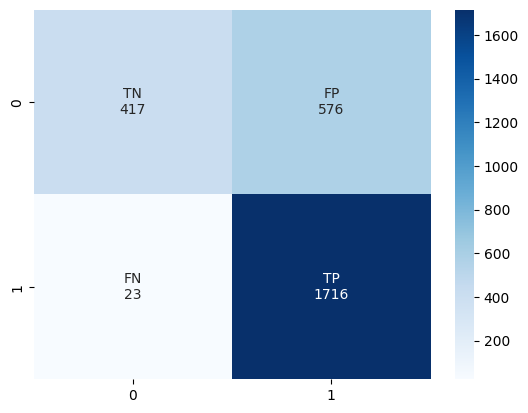

In [27]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [40]:
confusion_matrix_logistic = confusion_matrix(y_test, y_pred, labels=[1,0])
confusion_matrix_logistic

array([[1716,   23],
       [ 576,  417]], dtype=int64)

Text(0.5, 1.0, 'Confusion matrix Logistic Regression')

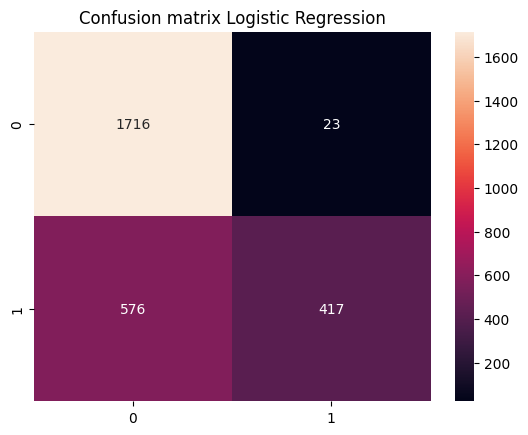

In [41]:
# plot the confusion matrix
ax = plt.axes()
sns.heatmap(confusion_matrix_logistic, annot=True, fmt="d")
ax.set_title('Confusion matrix Logistic Regression')